In [17]:
import sys
sys.path.append('reflutils')
import pyref as ru
import numpy as np
from pathlib import Path

%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
import pandas as pd
import pickle
import periodictable.xsf as xsf
sns.set_style("darkgrid")

# Bare Silicon

To start off with, we need a way to determine the thickness of silocon oxide present before deposition of the ZnPc. Thus we start by loading in the bare silicon data and fitting it to a model of just silicon and silicon oxide.

[None]

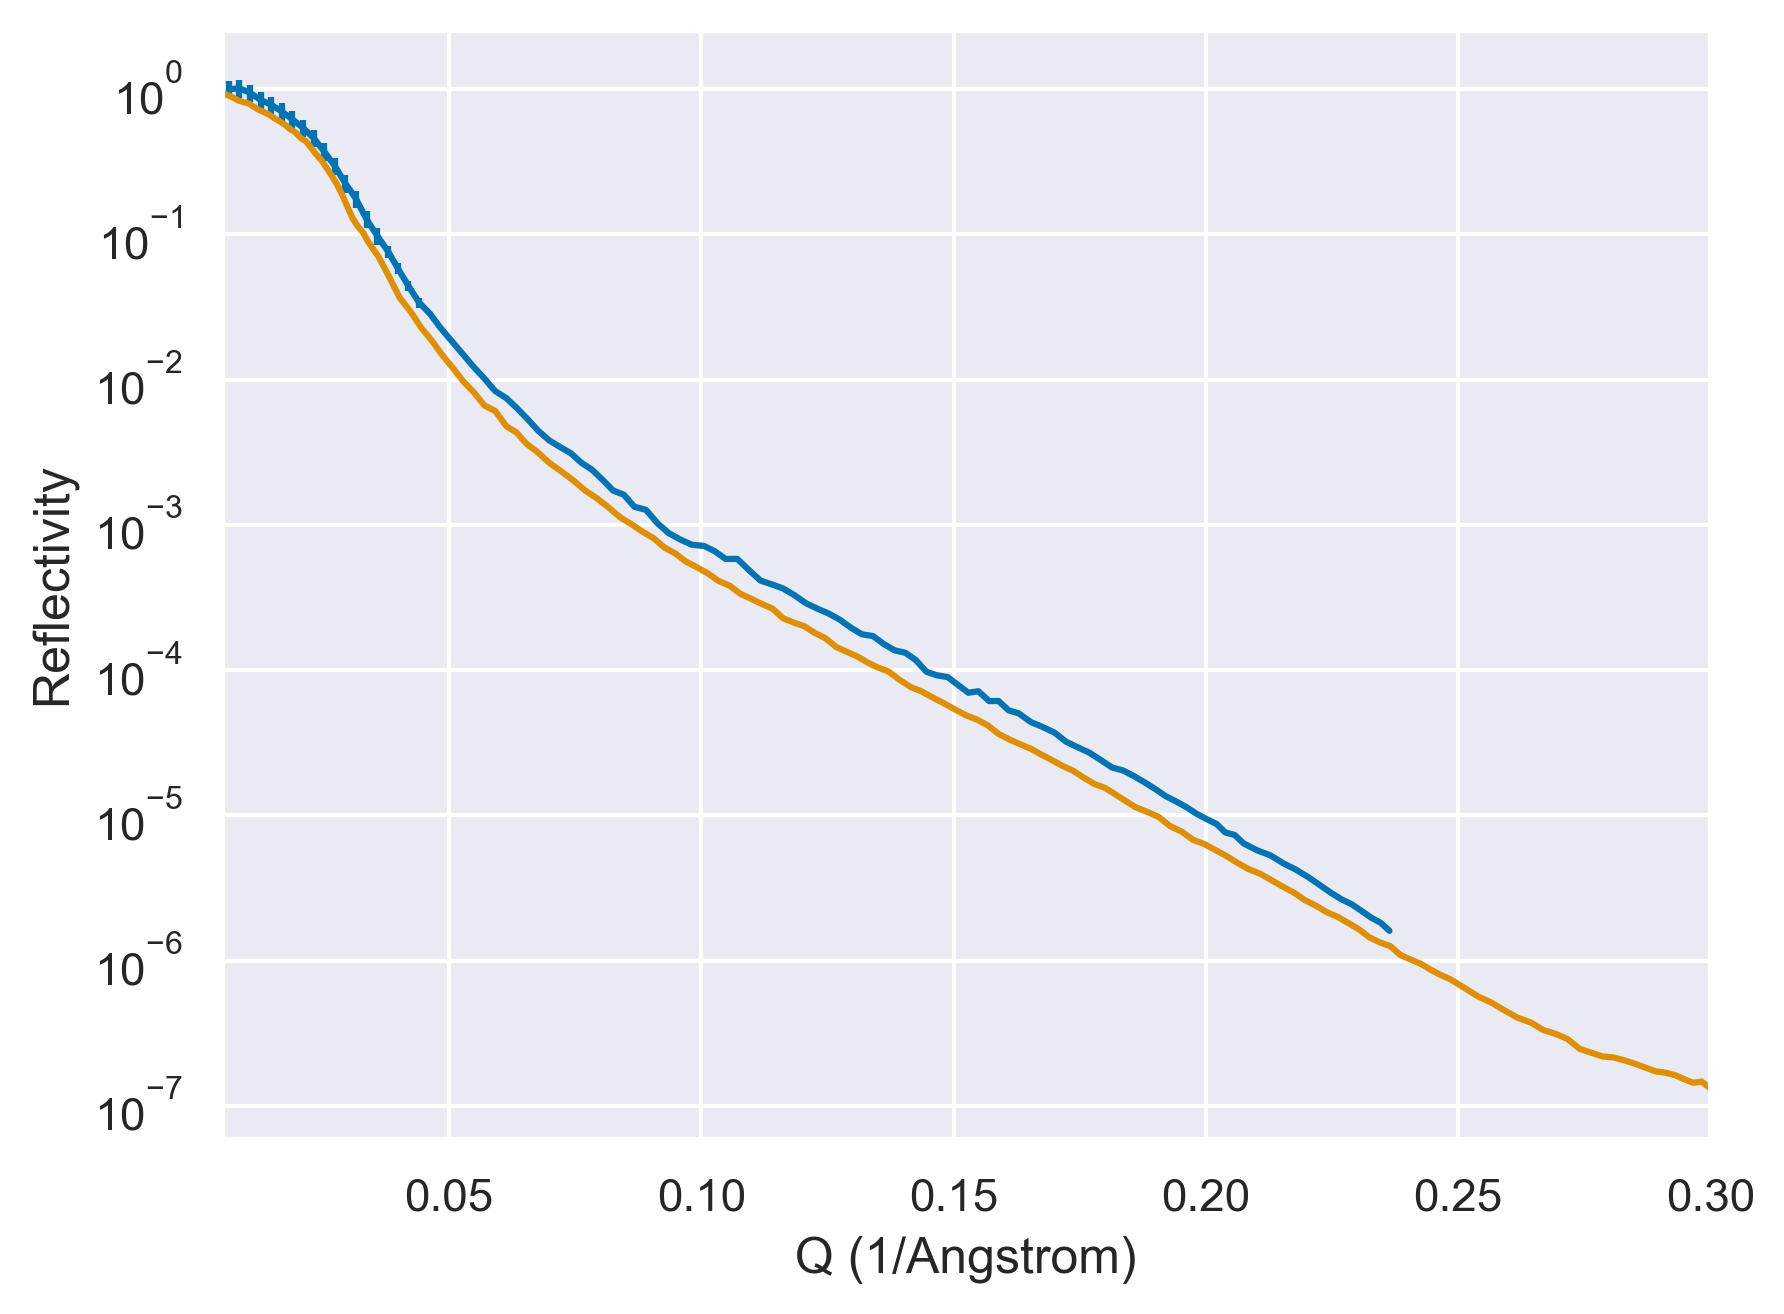

In [29]:
d_path = (
    Path.home()
    / "Washington State University (email.wsu.edu)"
    / "Carbon Lab Research Group - Documents"
    / "Harlan Heilman"
    / ".refl"
    / ".csv"
)

bareSi_250 = pd.read_csv(d_path / r"bareSi_250.csv", index_col=0)
bareSi_320 = pd.read_csv(d_path / r"bareSi_320.csv", index_col=0)


def ensure_nromalized(refl):
    refl.Refl = refl.Refl / refl.Refl.iloc[0]
    return refl


def to_refnx_dataset(refl):
    refl = ensure_nromalized(refl)
    data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)


bareSi_250_dataset = to_refnx_dataset(bareSi_250)
bareSi_320_dataset = to_refnx_dataset(bareSi_320)

fig, ax = plt.subplots()
bareSi_250_dataset.plot(fig=fig)
bareSi_320_dataset.plot(fig=fig)
ax.set(yscale="log", xlim=(0.005, 0.3), xlabel="Q (1/Angstrom)", ylabel="Reflectivity")
fig.set(dpi=300)

In [19]:
bareSi_250.iloc[0:5, :]

,Energy,Theta,Current,HOS,POL,Exposure,Intensity,Background,RawRefl,Refl,Err,Q,k,lam,lamErr
2,249.9967,1.428,499.9585,8.6,100.0,0.001,789558.0,56926.0,732632.0,1.000000,0.136553,0.0063,91502.76935,1401.442621,0.467007
3,249.9967,1.904,499.7899,8.6,100.0,0.001,798798.0,57227.0,741571.0,1.012543,0.138313,0.0084,91502.76935,1401.442621,0.467007
4,249.9948,2.382,499.9821,8.6,100.0,0.001,749874.0,57495.0,692379.0,0.945012,0.129039,0.0105,91502.76935,1401.442621,0.467007
5,249.9948,2.858,500.5215,8.6,100.0,0.001,675218.0,57229.0,617989.0,0.842570,0.114926,0.0126,91502.76935,1401.442621,0.467007
6,249.9929,3.334,500.3842,8.6,100.0,0.001,630384.0,57660.0,572724.0,0.781070,0.106567,0.0147,91502.76935,1401.442621,0.467007


[0.00366965+0.00024039j 0.00288176+0.00269286j]


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

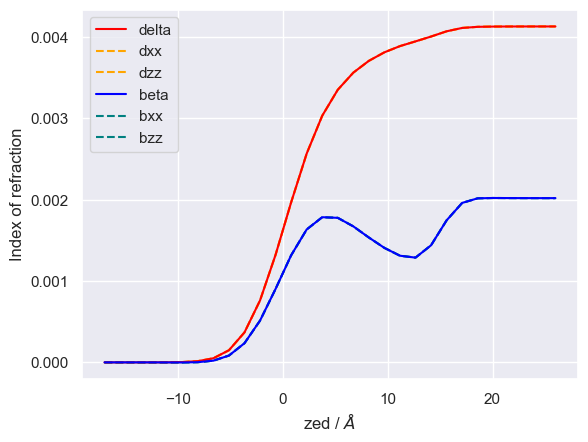

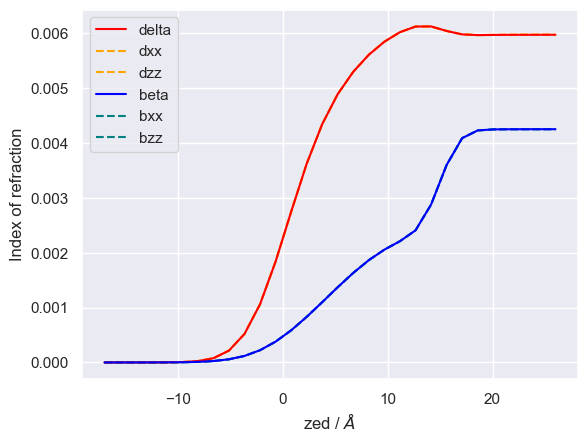

In [20]:
en = [250, 320]


def get_delta_beta(n):
    delta = 1 - n.real
    beta = -n.imag
    return delta + 1j * beta



_n_c = xsf.index_of_refraction("C", density=2.2, energy=[250e-3, 320e-3])
n_c = get_delta_beta(_n_c)
print(n_c)


max_thick = 16  # 1.6  x Vase

max_rough = 8  # 1.3  x Vase


sio2_t = 10
sio2_r = 5

carbon_t = 5
carbon_r = 3

vac = PXR_MaterialSLD("", 1)(0, 0)
si = [PXR_MaterialSLD("Si", 2.33, energy=e, name="Si")(0, 1.5) for e in en]
sio2 = [PXR_MaterialSLD("SiO2", 2.4, energy=e, name="SiO2")(sio2_t, sio2_r) for e in en]
carbon = [PXR_SLD(n, symmetry="iso", name="Carbon")(carbon_t, carbon_r) for n in n_c]

structure_0 = vac | carbon[0] | sio2[0] | si[0]
structure_1 = vac | carbon[1] | sio2[1] | si[1]

structure_1.plot()
structure_0.plot()

In [30]:
from Logp import LogpExtra_rough

scale_vary = False
scale_lb = 0.6
scale_ub = 1.2

bkg_vary = False
bkg_lb = 1e-9
bkg_ub = 9e-6

random_state = 1
nwalkers = 100
nsamples = 200

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
chain_name = "bareSi.txt"
save_fitter = "bareSi.pkl"

model_0 = PXR_ReflectModel(
    structure_0, scale=1, bkg=0, dq=0, energy=en[0], pol="s", name=f"BareSi_{en[0]}"
)
model_1 = PXR_ReflectModel(
    structure_1, scale=1, bkg=0, dq=0, energy=en[1], pol="s", name=f"BareSi_{en[1]}"
)

model_0.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model_1.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model_0.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))
model_1.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))

objective_0 = Objective(
    model_0, bareSi_250_dataset, transform=Transform("logY"), name=f"obj_{en[0]}"
)
objective_1 = Objective(
    model_1, bareSi_320_dataset, transform=Transform("logY"), name=f"obj_{en[1]}"
)
lpe1 = LogpExtra_rough(objective_0)
objective_0.logp_extra = lpe1

objective = GlobalObjective([objective_0, objective_1])

In [31]:
sio2[0].thick.setp(vary=True, bounds=(8, max_thick))
sio2[0].rough.setp(vary=True, bounds=(0, max_rough))
sio2[0].sld.density.setp(vary=True, bounds=(1.5, 2.5))

carbon[0].thick.setp(vary=True, bounds=(3, max_thick / 2))
carbon[0].rough.setp(vary=True, bounds=(0, max_thick / 2))
carbon[0].sld.delta.setp(vary=True, bounds=(0.0001, 0.01))
carbon[0].sld.beta.setp(vary=True, bounds=(0.00001, 0.01))

sio2[1].thick.setp(vary=None, constraint=(sio2[0].thick))
sio2[1].rough.setp(vary=None, constraint=(sio2[0].rough))
sio2[1].sld.density.setp(vary=True, bounds=(1.5, 2.5))


carbon[1].thick.setp(vary=None, constraint=(carbon[0].thick))
carbon[1].rough.setp(vary=None, constraint=(carbon[0].rough))
carbon[1].sld.delta.setp(vary=True, bounds=(0.0001, 0.01))
carbon[1].sld.beta.setp(vary=True, bounds=(0.00001, 0.01))

print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=5.14998 +/- 0.0795, bounds=[3.0, 8.0]>
<Parameter: 'Carbon_diso' , value=0.00504031 +/- 0.00335, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.0049887 +/- 0.00336, bounds=[1e-05, 0.01]>
<Parameter:'Carbon_rough' , value=4.06781 +/- 0.0649, bounds=[0.0, 8.0]>
<Parameter: 'SiO2_thick'  , value=9.58592 +/- 0.16 , bounds=[8.0, 16.0]>
<Parameter:     'rho'     , value=1.818 +/- 0.0187, bounds=[1.5, 2.5]>
<Parameter: 'SiO2_rough'  , value=5.37811 +/- 0.179, bounds=[0.0, 8.0]>
<Parameter: 'Carbon_diso' , value=0.00501483 +/- 0.00329, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00492493 +/- 0.00337, bounds=[1e-05, 0.01]>
<Parameter:     'rho'     , value=2.49808 +/- 0.00221, bounds=[1.5, 2.5]>


  0%|          | 0/2000 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\refl\Lib\site-packages\refnx\_lib\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [03:53<00:00,  8.58it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=6.08467 +/- 0.0038, bounds=[3.0, 8.0]>
<Parameter: 'Carbon_diso' , value=0.00495436 +/- 0.00282, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00498704 +/- 0.00291, bounds=[1e-05, 0.01]>
<Parameter:'Carbon_rough' , value=4.40733 +/- 0.000282, bounds=[0.0, 8.0]>
<Parameter: 'SiO2_thick'  , value=8.00003 +/- 0.00351, bounds=[8.0, 16.0]>
<Parameter:     'rho'     , value=1.62331 +/- 0.0121, bounds=[1.5, 2.5]>
<Parameter: 'SiO2_rough'  , value=6.38308 +/- 0.000286, bounds=[0.0, 8.0]>
<Parameter: 'Carbon_diso' , value=0.00500573 +/- 0.00284, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00477821 +/- 0.0029, bounds=[1e-05, 0.01]>
<Parameter:     'rho'     , value=2.49998 +/- 0.000806, bounds=[1.5, 2.5]>


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

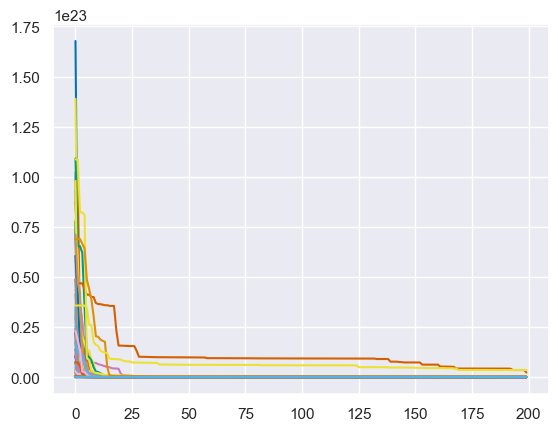

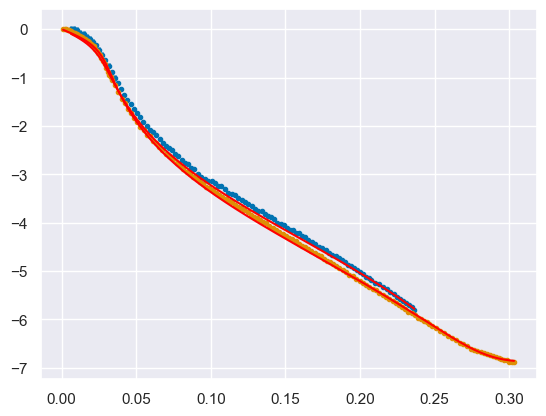

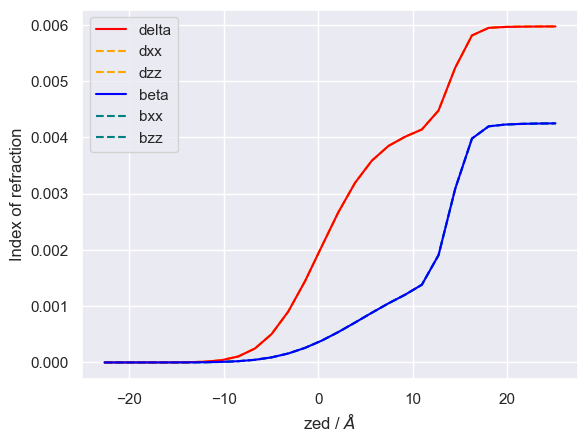

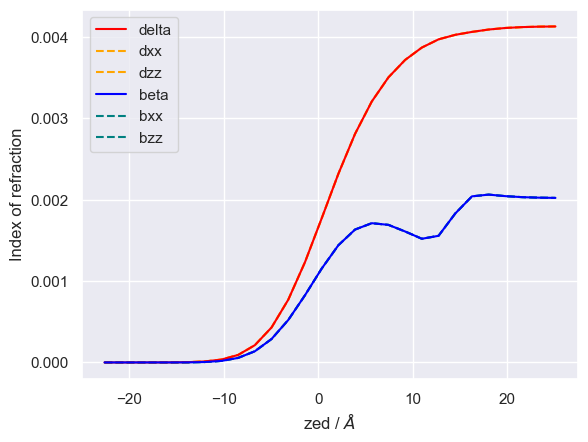

In [33]:
fitter = CurveFitter(objective, nwalkers=nwalkers, moves=move)
fitter.initialise("jitter")
chain = fitter.sample(int(nsamples), nthin=10, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(objective.varying_parameters())
objective.plot()
structure_0.plot()
structure_1.plot()

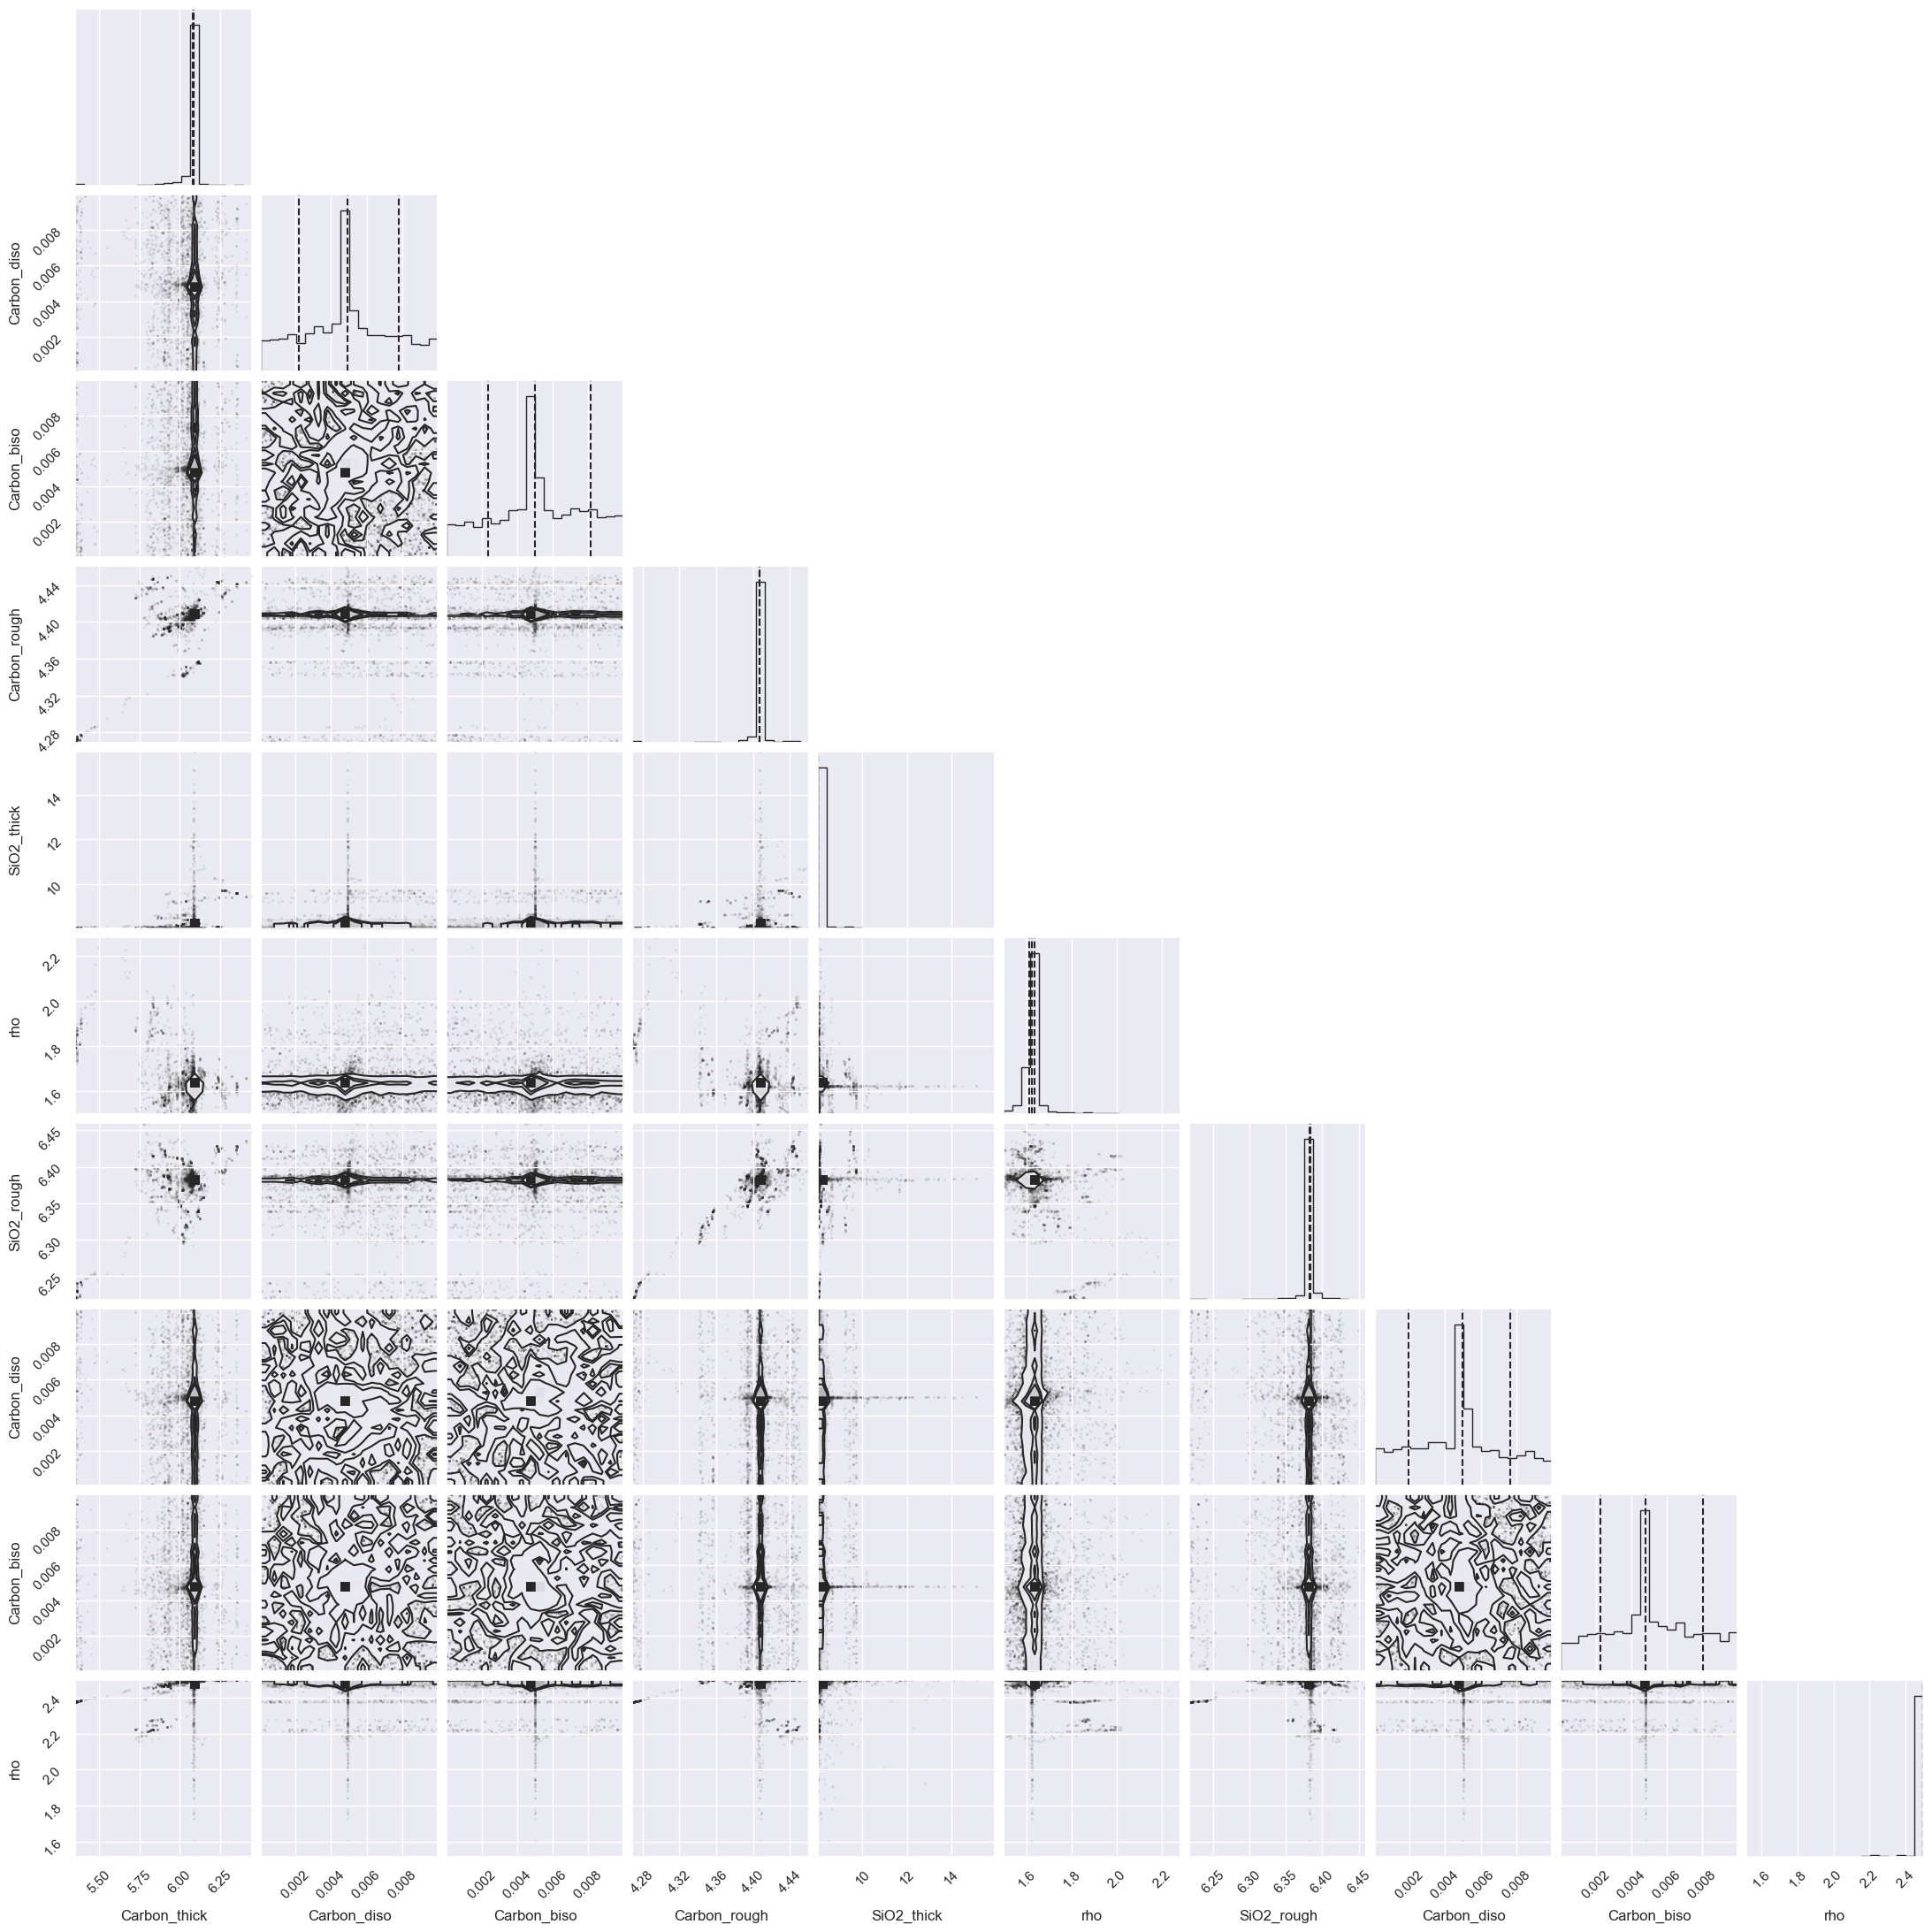

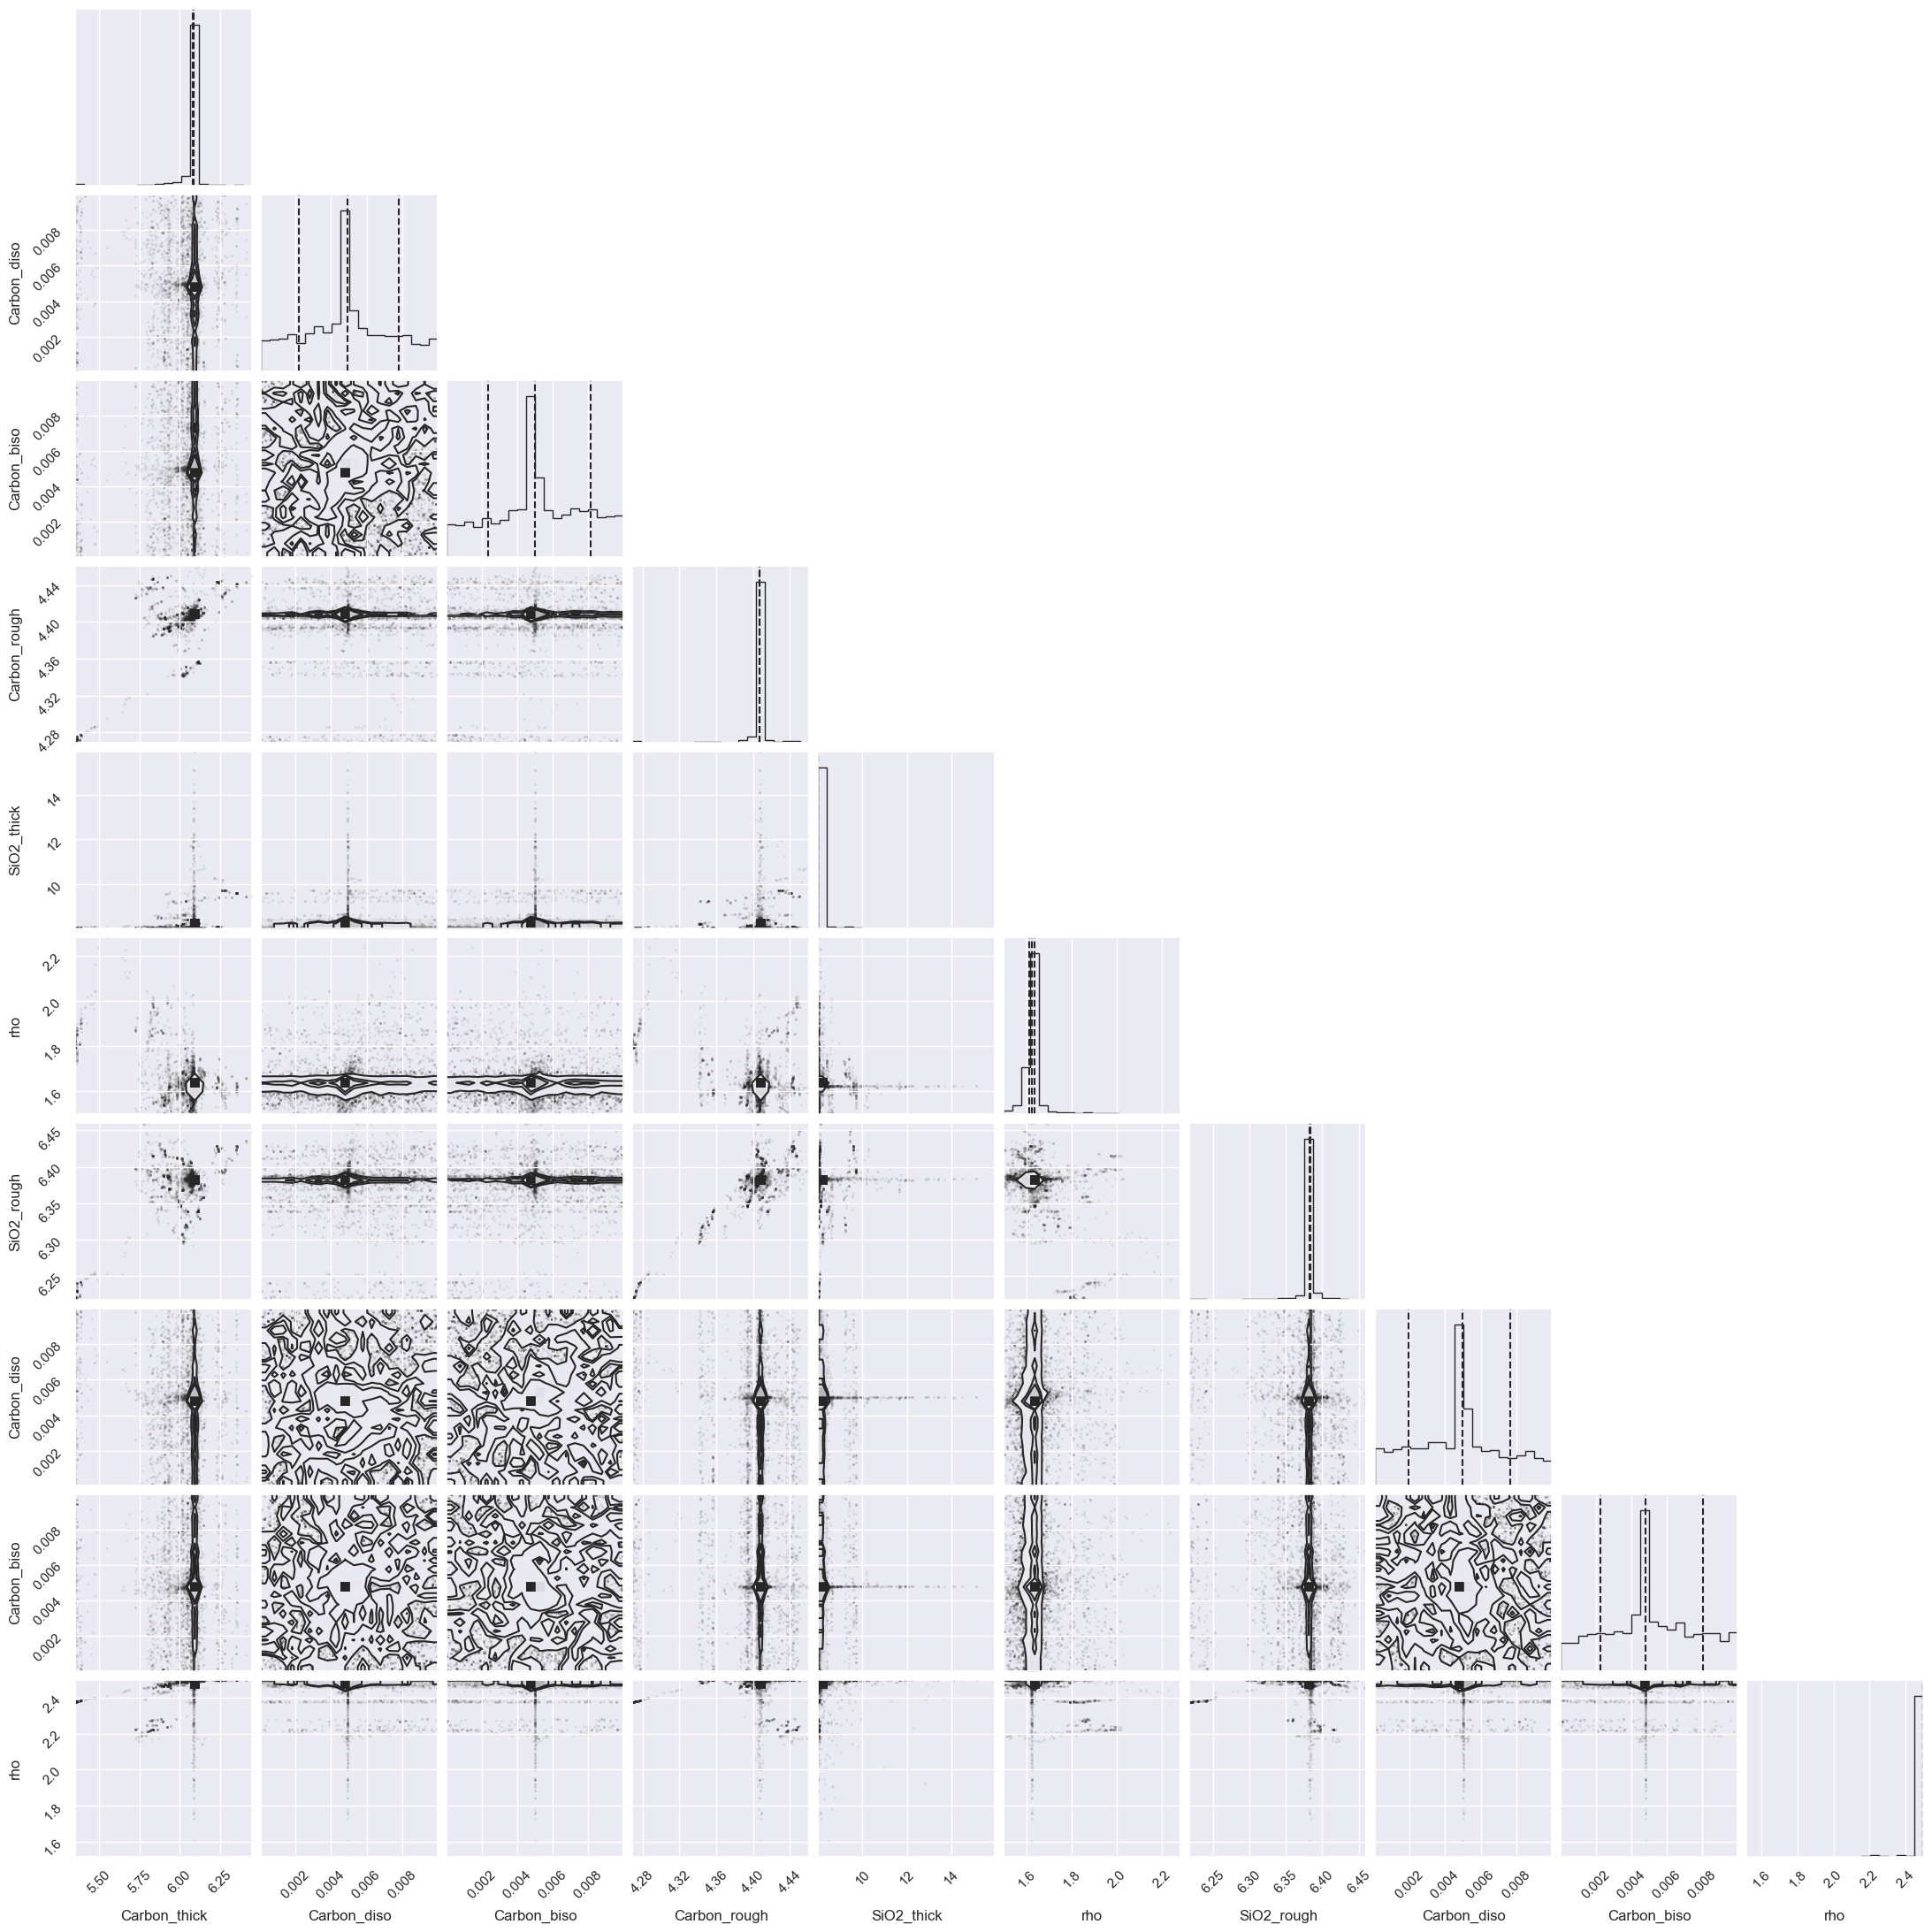

In [34]:
objective.corner()

In [35]:
with open(d_path / save_fitter, "wb") as f:
    pickle.dump(fitter, f)

with open(d_path / chain_name, "wb") as f:
    f.write(str(objective_0.parameters).encode())

In [ ]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=6.37633 +/- 1.03 , bounds=[0.0, 16.0]>
<Parameter: 'Carbon_diso' , value=0.00492104 +/- 0.00327, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00214144 +/- 0.00299, bounds=[1e-05, 0.01]>
<Parameter:'Carbon_rough' , value=4.02044 +/- 0.549, bounds=[0.0, 8.0]>
<Parameter:'Sillicon Dioxide_thick', value=6.62495 +/- 1.25 , bounds=[0.0, 16.0]>
<Parameter:     'rho'     , value=1.72559 +/- 0.35 , bounds=[1.5, 2.5]>
<Parameter:'Sillicon Dioxide_rough', value=5.05252 +/- 0.885, bounds=[0.0, 8.0]>
<Parameter: 'Carbon_diso' , value=0.00406964 +/- 0.00318, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00351381 +/- 0.00303, bounds=[1e-05, 0.01]>
<Parameter:     'rho'     , value=2.47648 +/- 0.0792, bounds=[1.5, 2.5]>


________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=5.3098 +/- 3.43 , bounds=[0.0, 16.0]>
<Parameter: 'Carbon_diso' , value=0.00309775 +/- 0.0022, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00379114 +/- 0.00296, bounds=[1e-05, 0.01]>
<Parameter:'Carbon_rough' , value=4.48366 +/- 1.54 , bounds=[0.0, 8.0]>
<Parameter:'Sillicon Dioxide_thick', value=6.62713 +/- 4.51 , bounds=[0.0, 16.0]>
<Parameter:     'rho'     , value=2.20713 +/- 0.291, bounds=[1.5, 2.5]>
<Parameter:'Sillicon Dioxide_rough', value=7.09094 +/- 5.93 , bounds=[0.0, 8.0]>
________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=5.3098 +/- 3.43 , bounds=[0.0, 16.0]>
<Parameter: 'Carbon_diso' , value=0.00368415 +/- 0.00289, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.000449867 +/- 0.000446, bounds=[1e-05, 0.01]>
<Paramet

(<Figure size 640x480 with 1 Axes>, <Axes: >)

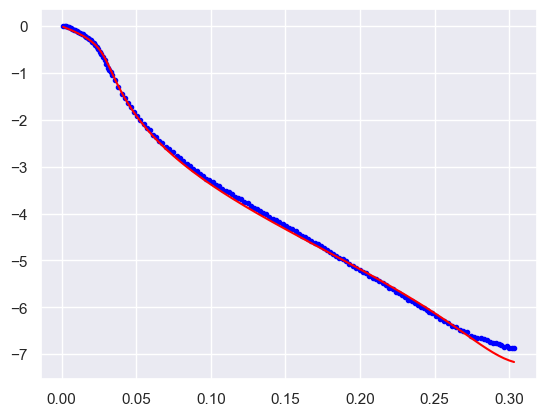

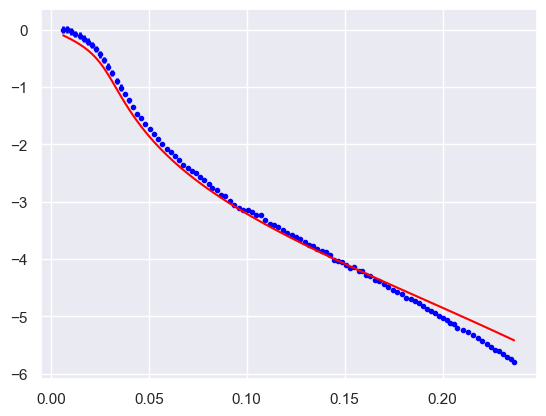

In [117]:
chain_name = "bareSi_320.txt"
save_fitter = "bareSi_320.pkl"

model_1 = PXR_ReflectModel(
    structure_1, scale=1, bkg=0, dq=0, energy=en[1], pol="s", name=f"BareSi_{en[1]}"
)
model_1.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model_1.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))

objective_1 = Objective(
    model_1, bareSi_320_dataset, transform=Transform("logY"), name=f"obj_{en[0]}"
)
lpe = LogpExtra_rough(objective_1)
objective_1.logp_extra = lpe

objective_1.plot()
print(objective_1.varying_parameters())
print(objective_0.varying_parameters())
objective_0.plot()

100%|██████████| 2000/2000 [04:56<00:00,  6.74it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=5.3098 +/- 3.43 , bounds=[0.0, 16.0]>
<Parameter: 'Carbon_diso' , value=0.00309775 +/- 0.0022, bounds=[0.0001, 0.01]>
<Parameter: 'Carbon_biso' , value=0.00379114 +/- 0.00296, bounds=[1e-05, 0.01]>
<Parameter:'Carbon_rough' , value=4.48366 +/- 1.54 , bounds=[0.0, 8.0]>
<Parameter:'Sillicon Dioxide_thick', value=6.62713 +/- 4.51 , bounds=[0.0, 16.0]>
<Parameter:     'rho'     , value=2.20713 +/- 0.291, bounds=[1.5, 2.5]>
<Parameter:'Sillicon Dioxide_rough', value=7.09094 +/- 5.93 , bounds=[0.0, 8.0]>


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

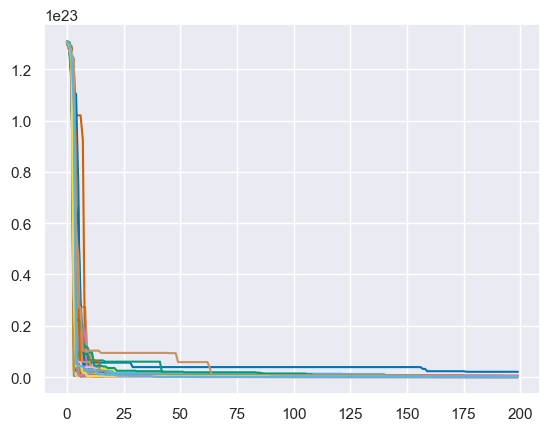

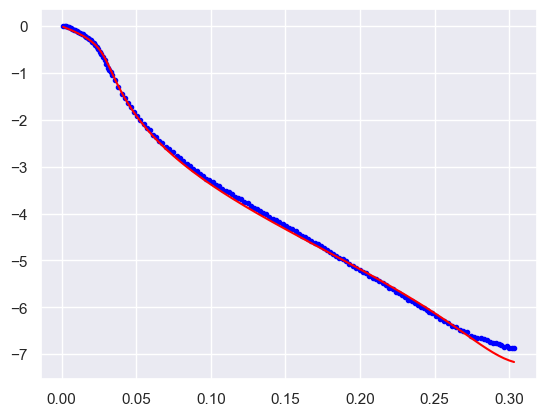

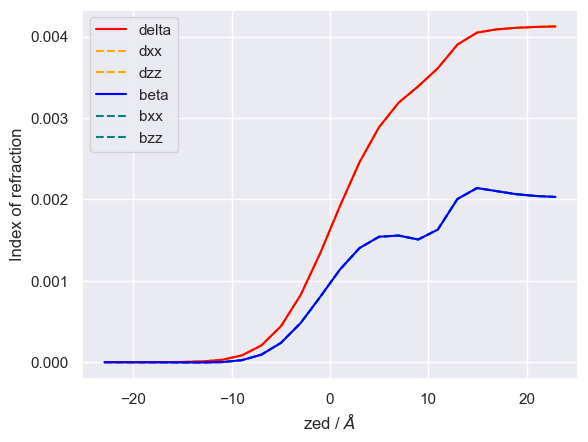

In [112]:
fitter_1 = CurveFitter(objective_1, nwalkers=nwalkers, moves=move)
fitter_1.initialise("jitter")
chain_1 = fitter_1.sample(
    nsamples, f=d_path / chain_name, nthin=10, random_state=random_state
)
lp1 = fitter_1.logpost
plt.plot(-lp1)

print(objective_1.varying_parameters())
objective_1.plot()
structure_1.plot()

In [ ]:
with open(d_path / save_fitter, "wb") as f:
    pickle.dump(fitter_0, f)

with open(d_path / chain_name, "wb") as f:
    f.write(str(objective_0.parameters).encode())